In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import torch 
from torch import nn
from torch.nn import functional as F

torch.__version__

'1.13.1'

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## DCGAN - Deep Convolutional GAN

### Dataset

In [3]:
import torchvision 
from torchvision import transforms 


image_path = './data/'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])
mnist_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=True, 
                                           transform=transform, 
                                           download=False)

batch_size = 64

torch.manual_seed(1)
np.random.seed(1)

## Set up the dataset
from torch.utils.data import DataLoader
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, 
                      shuffle=True, drop_last=True)

In [4]:
def make_generator_network(input_size, n_filters):

    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters*4, kernel_size=4, stride=1, padding=0,bias=False),
        nn.BatchNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*4, n_filters*2, kernel_size=3, stride=2, padding=1,bias=False),
        nn.BatchNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*2, n_filters, kernel_size=4, stride=2, padding=1,bias=False),
        nn.BatchNorm2d(n_filters),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh()
    )

    return model

In [5]:
class Discriminator(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters, n_filters*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*2, n_filters*4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*4, 1, 4, 1, 0, bias=False),
            # nn.Sigmoid()
            )
        
    def forward(self, x):
        output = self.network(x)
        return output.view(-1, 1).squeeze(0)

In [6]:
z_size = 100
image_size = (28, 28)
n_filters = 32 
gen_model = make_generator_network(z_size, n_filters).to(device)
print(gen_model)
print()

disc_model = Discriminator(n_filters=n_filters).to(device)
print(disc_model)

Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)

Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1,

In [7]:
loss_fn = nn.BCEWithLogitsLoss()

g_optimizer = torch.optim.Adam(gen_model.parameters(), lr=0.0003)
d_optimizer = torch.optim.Adam(disc_model.parameters(), lr=0.0002)

In [8]:
# Creating z
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        return torch.rand(batch_size, z_size, 1, 1)*2 -1
    elif mode_z == 'normal':
        return torch.randn(batch_size, z_size, 1, 1)

In [9]:
# Training the discriminator
def d_train(x, mode_z):
    disc_model.zero_grad()

    # Training on real images
    batch_size = x.size(0)
    d_labels_real = torch.ones(size=(batch_size, 1), device=device)

    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)


    # Training on generated images
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)

    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(size=(batch_size, 1), device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    # Gradient backprop on discriminator only
    #Minmax loss
    d_loss = d_loss_real + d_loss_fake

    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

In [10]:
# Training the generator
def g_train(x, mode_z):
    gen_model.zero_grad()

    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    # Fake labels
    # Used to train the gan more effectively.
    # Since the d model was train on the true labels (false= false images ,true=real images), Having a fake labels as 1 will result in a higher loss which is used to train the generator in greater size.
    g_labels_real = torch.ones( size=(batch_size, 1), device=device )

    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)

    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()

In [11]:
mode_z = 'normal'
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images+1) / 2. 

epoch_samples = []

num_epochs = 100
torch.manual_seed(1)

for epoch in range(1, num_epochs+1):
    gen_model.train()
    d_losses, g_losses = [], []

    for i, (x,_) in enumerate(mnist_dl):
        x = x.to(device)
        
        d_loss, d_proba_real, d_proba_fake = d_train(x, mode_z)
        d_losses.append(d_loss)
        g_losses.append(g_train(x, mode_z))

    print(f'Epoch {epoch:03d} | Avg Losses >> ' + f'G/D {torch.FloatTensor(g_losses).mean():.4f}' + f'/{torch.FloatTensor(d_losses).mean():.4f}')

    gen_model.eval()
    epoch_samples.append(create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 001 | Avg Losses >> G/D 4.6294/0.1101
Epoch 002 | Avg Losses >> G/D 4.2991/0.1876
Epoch 003 | Avg Losses >> G/D 3.4942/0.3102
Epoch 004 | Avg Losses >> G/D 2.8776/0.3654
Epoch 005 | Avg Losses >> G/D 2.7821/0.3615
Epoch 006 | Avg Losses >> G/D 2.7874/0.3372
Epoch 007 | Avg Losses >> G/D 2.8834/0.3325
Epoch 008 | Avg Losses >> G/D 2.9460/0.3032
Epoch 009 | Avg Losses >> G/D 3.0444/0.2819
Epoch 010 | Avg Losses >> G/D 3.0948/0.2772
Epoch 011 | Avg Losses >> G/D 3.0811/0.2671
Epoch 012 | Avg Losses >> G/D 3.1854/0.2629
Epoch 013 | Avg Losses >> G/D 3.2175/0.2639
Epoch 014 | Avg Losses >> G/D 3.2640/0.2349
Epoch 015 | Avg Losses >> G/D 3.3938/0.2207
Epoch 016 | Avg Losses >> G/D 3.4190/0.2366
Epoch 017 | Avg Losses >> G/D 3.4541/0.2220
Epoch 018 | Avg Losses >> G/D 3.5671/0.2054
Epoch 019 | Avg Losses >> G/D 3.5958/0.2050
Epoch 020 | Avg Losses >> G/D 3.5540/0.2139
Epoch 021 | Avg Losses >> G/D 3.6782/0.1980
Epoch 022 | Avg Losses >> G/D 3.6486/0.2105
Epoch 023 | Avg Losses >> G/D 3.

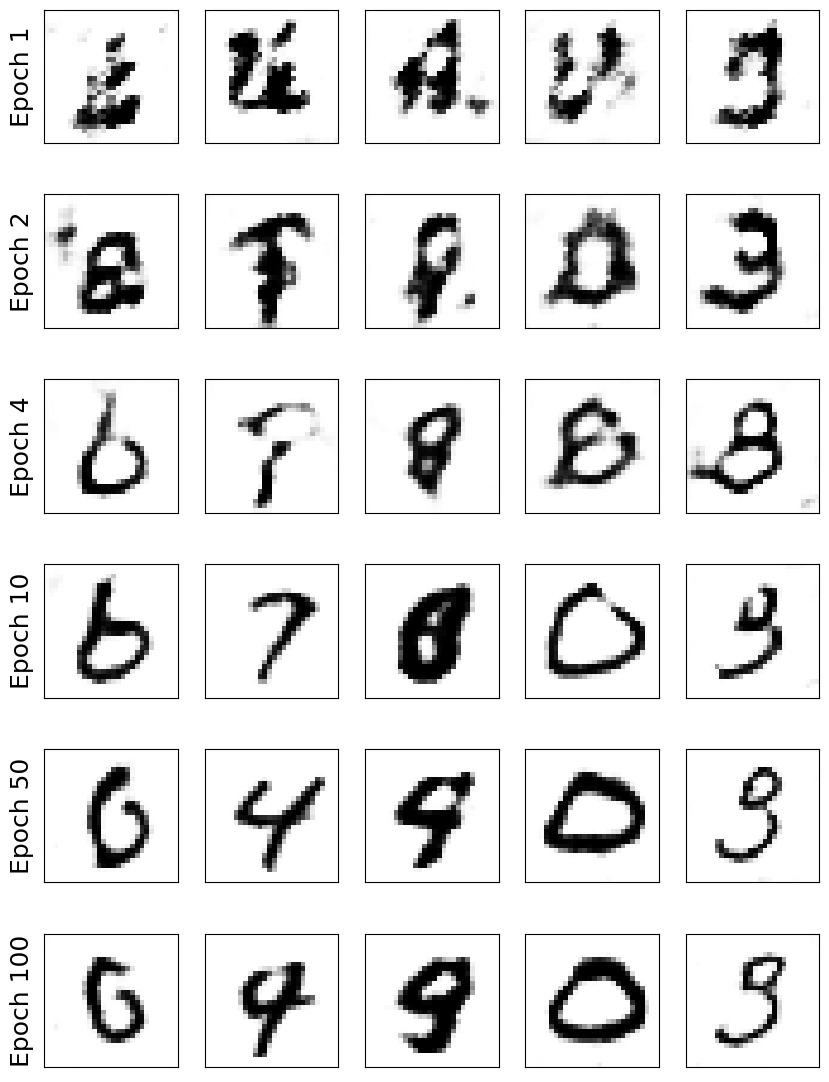

In [14]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))

for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.set_ylabel(f'Epoch {e}', size=18)
            # ax.text(
            #     -0.06, 0.5, f'Epoch {e}',
            #     rotation=90, size=18, color='red',
            #     horizontalalignment='right',
            #     verticalalignment='center', 
            #     transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
plt.show()